# Word2Vec-SVC Classifier

word2vec by Google and spaCy tokenizer

word2vec is an NLP algorithm that uses a neural network to learn associations between words.
It is used to convert words tokenised by the spaCy library from the text dataset into word vectors
for an SVM. The word vectors for each set of tokens are averaged to generate a sentence
vector that is fed into the classification model.

## Data Processing

In [1]:
import gensim.downloader as api

word_vect = api.load('word2vec-google-news-300')

In [2]:
import spacy

nlp = spacy.load('en_core_web_md')

In [3]:
# tokenises a sentence using spacy library
def spacy_tokenizer(text):
    doc = nlp(text)

    # lemmatise tokens
    tokens = [word.lemma_.strip() for word in doc]

    return tokens

In [4]:
import numpy as np

# takes a tokenized sentence input from spacy and takes average of all word vectors
def sentence_vect(tokens):
    # word2vec output size (300 for word2vec-google-news-300)
    size = word_vect.vector_size

    # create a vector of zeroes
    sent_vect = np.zeros(size)

    # get average of all word vectors of each token
    counter = 0
    for word in tokens:
        if word in word_vect:
            sent_vect += word_vect[word]
            counter += 1

    if counter == 0:
        return None

    sent_vect = sent_vect / counter
    return sent_vect

In [5]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('blooms_dataset.csv')

# removes all punctuations and change to lower case
df['Text'] = df['Text'].str.replace(r'[^\w\s]+', '', regex=True)
df['Text'] = df['Text'].str.lower()

df['Label'] = pd.factorize(df.Label)[0]
# df['Label'].value_counts()

# Change categories into numbers
# Analyse - 0
# Apply - 1
# Create - 2
# Evaluate - 3
# Remember - 4
# Understand - 5

# Blooms taxonomy categories
categories = ['Analyse', 'Apply', 'Create', 'Evaluate', 'Remember', 'Understand']

In [6]:
# add a row of tokenised text
df['Tokens'] = df['Text'].apply(spacy_tokenizer)

In [7]:
# create sentence vectors by taking average of token vectors
df['Vectors'] = df['Tokens'].apply(sentence_vect)

# drop all null values after tokenizing as some cells may not have relevant data
df = df.dropna(axis=0, subset=['Vectors'])

In [8]:
from sklearn.model_selection import train_test_split

# X - sentence vectors (Vectors)
# Y - blooms category (Label)

# split data into training and test set (0.8, 0.2)
train, test = train_test_split(df, test_size=0.2)

## Model Building

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       123
           1       0.74      0.72      0.73       129
           2       0.93      0.75      0.83        92
           3       0.86      0.86      0.86       112
           4       0.79      0.85      0.82       294
           5       0.81      0.85      0.83       485

    accuracy                           0.81      1235
   macro avg       0.83      0.79      0.80      1235
weighted avg       0.82      0.81      0.81      1235

Accuracy: 0.8129554655870446


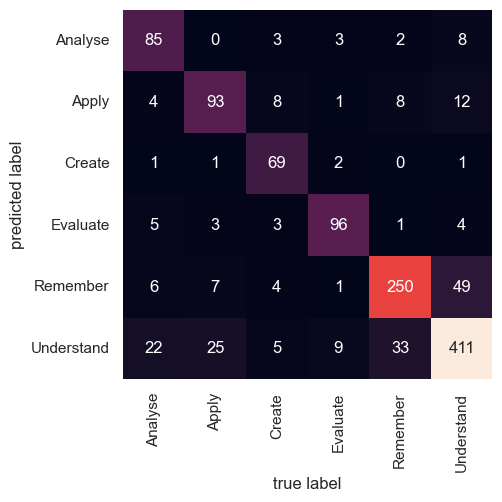

In [9]:
from sklearn.svm import SVC

# model based on Support Vector Machine (non-probabilistic classifier)
model = SVC(kernel='linear', gamma='auto', degree=3)

# Fit sentence vectors to labels
model.fit(list(train.Vectors), train.Label)

# Generate blooms label on test set
labels = model.predict(list(test.Vectors))


# model report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Heatmap of model
mat = confusion_matrix(test.Label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False
            , xticklabels=categories
            , yticklabels=categories)

plt.xlabel('true label')
plt.ylabel('predicted label')

print(classification_report(test.Label, labels))
# Model Accuracy, how often is the classifier correct?

acc = accuracy_score(test.Label, labels)
print("Accuracy:", acc)

## Prediction Testing

In [10]:
category_dict = {0: 'Analyse', 1: 'Apply', 2: 'Create', 3: 'Evaluate', 4: 'Remember', 5: 'Understand'}

def predict_blooms(text, model):
    process = spacy_tokenizer(text)
    process = sentence_vect(process)
    blooms = model.predict([process])
    print("Predicted Class:", category_dict[blooms[0]])

In [11]:
print(categories, "\n")

task = "Develop an agile plan for the upcoming project"

print("\nSVM PREDICTION:")
predict_blooms(task, model)

['Analyse', 'Apply', 'Create', 'Evaluate', 'Remember', 'Understand'] 


SVM PREDICTION:
Predicted Class: Apply
